In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import DataSet, DataSetNump, pre_process_all_data
from utils.functions import get_rv_from_yahoo, get_rv_from_data, get_tickers_in_data, print_nicely, reset_model_weights, plot_tickers_in_data
from utils.modelbuilder import ForwardNeuralNetwork

# diebold mariano to compare the prediction accuracy of two different models
from dieboldmariano import dm_test

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI', '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX', '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20', '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC', '.SSMI', '.STI', '.STOXX50E']


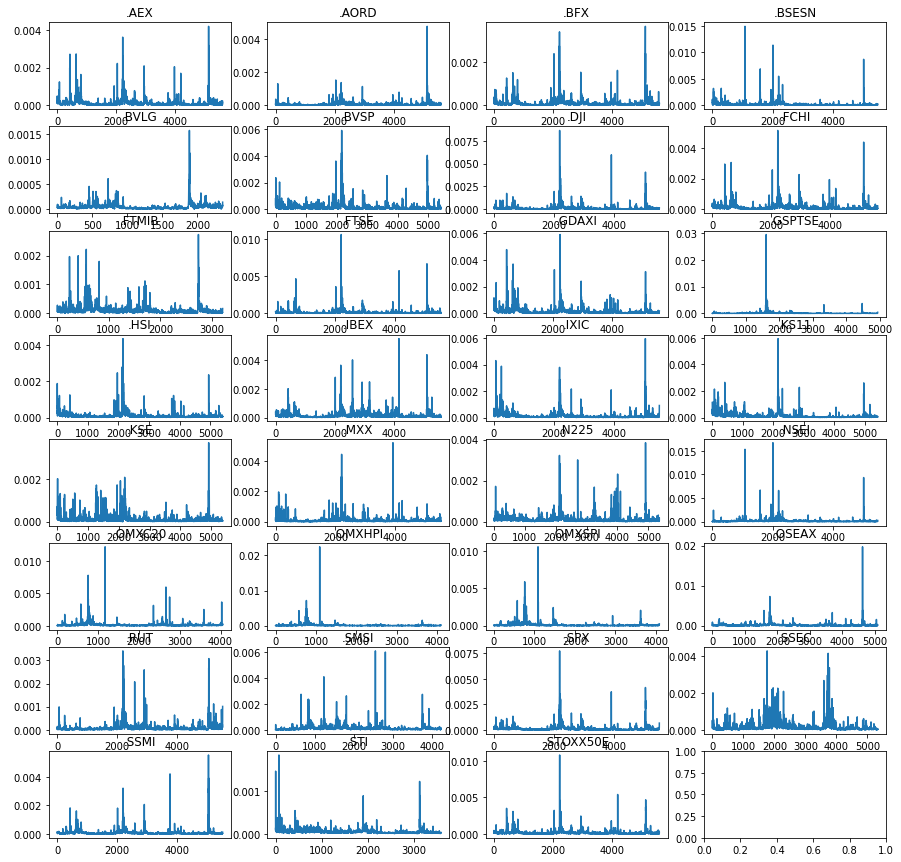

None


In [2]:
print(get_tickers_in_data())
print(plot_tickers_in_data())

Total of 5530 found for symbol: .SPX
Total training observations: 5208
Total validation observations: 300


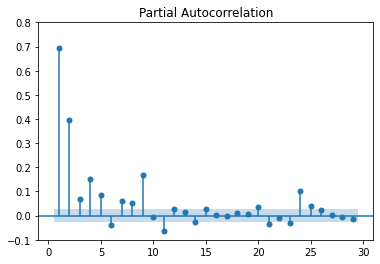

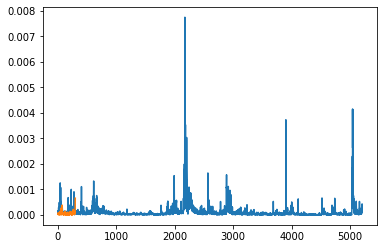

0.000111803434
4.8526617e-05


In [3]:
# fetch data through yahoo finance API, compute features, split into training and validation subsets
# ... for both NN and HAR

ticker = ".SPX" # .SSEC or .SPX

# data = get_rv_from_yahoo(ticker)
# or use ...
data = get_rv_from_data(ticker)
n_observations = len(data)
print(f"Total of {n_observations} found for symbol: {ticker}")

# data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, train_size=.8)
data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, test_size = 300)

train_observations, test_observations = len(data_nn_train), len(data_nn_val)
print(f"Total training observations: {train_observations}")
print(f"Total validation observations: {test_observations}")

# to determine gap used in TimeSeriesSplit
plot_pacf(data_har_train.y, lags = range(1, 30))
plt.ylim(-0.1, 0.8)
plt.show()
plt.plot(data_har_train.y)
plt.plot(data_har_val.y)
plt.show()

print(np.average(data_har_train.y))
print(np.average(data_har_val.y))

### In-Sample Neural Network Estimatiom
Is it, within the parameter space of the neural network, possible to even match the HAR performance?

In [9]:
def fit_in_sample_return_lowest_loss_epoch(model: nn.Module, data_train, lr: int, batch_size: int, epochs: int, earlystopper: EarlyStopper, verbose=1):
    """ 
    On train data, fit model, predict model and store loss for each epoch.
    After completing all epochs, or if early stopper was triggered, return the lowest loss observed
    """
     
    # NOTE: SHOULD SHUFFLE BE TRUE OR FALSE, WAS FALSE UNTIL NOW
    trainloader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
            
    # initialize and train the model
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    lowest_loss = float("inf")
    lowest_output = "placeholder"
    
    for epoch in range(1, epochs+1):
        
        # train_running_loss = []
        for batch in trainloader:
            
            # each batch contains one set of features and one set of targets
            batch_features: torch.Tensor = batch[0]
            batch_targets: torch.Tensor = batch[1]
        
            # reset gradient optimizer
            optimizer.zero_grad()
            
            # with the batch features, predict the batch targets
            output = model(batch_features)
            
            # compute the loss and .backward() computes the gradient of the loss function
            loss = criterion(output, batch_targets)
            loss.backward()
            
            # update parameters (something like: params += -learning_rate * gradient)
            optimizer.step()
            
            # keep track of loss to log improvements of the fit
            # train_running_loss.append(loss.item())

        # if testdata is also provided, compute the out-of-sample performance of the model
        with torch.no_grad():
            output = model(data_nn_train.x_t).detach().numpy().reshape(-1)
            resid = data_nn_train.y_t.detach().numpy().reshape(-1) - output
            train_running_loss = np.average(resid**2)
            
            # if a lower loss is found, store this + the models output for that epoch
            if train_running_loss < lowest_loss:
                lowest_loss = train_running_loss
                lowest_output = output
                
            if verbose > 0:
                print(f"epoch {epoch} - training loss: {train_running_loss}")
            running_loss = train_running_loss

        # if an early stopper is provided, check if validation loss is still improving
        # if not, stop the estimation
        if earlystopper:
            if earlystopper.early_stop(running_loss):
                break
    return lowest_loss, lowest_output

In [5]:
# PERFORM IN-SAMPLE FIT AND VALIDATION FOR HAR
HAR = OLS(endog=data_har_train.y, exog=data_har_train.x)
res = HAR.fit()
har_output = res.predict(data_har_train.x).reshape(-1,)
resid = data_har_train.y.reshape(-1,) - har_output.reshape(-1,)
har_loss = np.average(resid**2)
print(f"HAR in-sample loss: {har_loss}")

# PERFORM IN-SAMPLE GRID SEARCH FOR NN
model_scores = []

hidden_layers_list: tuple = ([2,],)
lr_list: tuple = (1e-3,)
epochs_list: tuple = (1000,)
patience_list: tuple = (20, 40)
batch_sizes: tuple = (10,)
repetitions = 10
total_model_options: int = len(hidden_layers_list) * len(lr_list) * len(epochs_list) * len(batch_sizes) * len(patience_list) * repetitions

# for all possible model and estimation configurations, perform kfold cross validation
lowest_loss = np.float("inf")
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patience_list:
                    for rep in range(repetitions):
                        counter += 1
                        
                        print(f"Currently at model: {counter} / {total_model_options} - lowest observed loss: {lowest_loss}", end="\r")
                        model = ForwardNeuralNetwork(
                                input_size = data_nn_train.x_t.shape[1],
                                output_size = 1,
                                hidden_layers = hidden_layers,
                                # seed=3407
                        )           
                        
                        loss, output = fit_in_sample_return_lowest_loss_epoch(
                            model,
                            data_nn_train,
                            lr,
                            batch_size,
                            epochs, 
                            earlystopper=EarlyStopper(patience=patience, min_delta=0),
                            verbose = 0
                        )
                        if loss < lowest_loss: 
                            lowest_loss = loss
                            best_output = output
                        # print("lowest loss of all epochs ", loss)
                        # print(f"model: hidden layers={hidden_layers} lr={lr} epochs={epochs} batch_size={batch_size} patience={patience}")
                        # print(f"loss func in-sample: {loss}")
                        
                        # store the models performance in array
                        model_scores += [(loss, epochs, hidden_layers, lr, batch_size, patience)]
                    
# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr", "batch_size", 'patience'])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation beneath
lowest_loss, epochs, hidden_layers, lr, batch_size, patience = df_scores.values[0]
epochs, batch_size = int(epochs), int(batch_size)

if lowest_loss > har_loss:
    print("ga maar wat beters doen met je tijd")
else:
    print("wie is HAR?")
print(f"HAR: {har_loss} NN: {lowest_loss}")

HAR in-sample loss: 3.482814747712837e-08
      avg_score  epochs hidden_nodes     lr  batch_size  patience69754e-08
0  3.484711e-08    1000          [2]  0.001          10        40
1  3.484798e-08    1000          [2]  0.001          10        20
2  3.485490e-08    1000          [2]  0.001          10        20
3  3.488197e-08    1000          [2]  0.001          10        20
4  3.488254e-08    1000          [2]  0.001          10        40
5  3.488307e-08    1000          [2]  0.001          10        20
6  3.488782e-08    1000          [2]  0.001          10        40
7  3.491444e-08    1000          [2]  0.001          10        40
8  3.491662e-08    1000          [2]  0.001          10        40
9  3.493135e-08    1000          [2]  0.001          10        20
ga maar wat beters doen met je tijd
HAR: 3.482814747712837e-08 NN: 3.4847108310032127e-08


In [6]:
# R^2 calculation of in sample fit
def evaluation(output_har, output_nn, data_train):

    avg = np.average(data_train)
    print('First R2 = HAR')
    print('Second R2 = ANN')
    for output in [output_har, output_nn]:
        ssr = 0
        sst = 0
        for i in range(len(data_train)):
            ssr += (data_train[i] - output[i])**2
            sst += (data_train[i] - avg)**2
            
        R2 = 1 - (ssr / sst)

        print('R2 of: {}'.format(R2))

    stat, p_value = dm_test(
    data_train, 
    output_nn,
    output_har,
    one_sided=True,
    )
    print("Diebold-Mariano test")
    print("H0: stat = 0, H1: stat < 0")
    print("I.e., p-val < p_crit implies NN performs significantly better")
    print(f"stat: {stat} p_val: {p_value}")

evaluation(output_har=har_output, output_nn=best_output, data_train=data_har_train.y.tolist())

First R2 = HAR
Second R2 = ANN
R2 of: 0.5181412194594182
R2 of: 0.5178788870297917
Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 0.22848591703777174 p_val: 0.5903610821249243


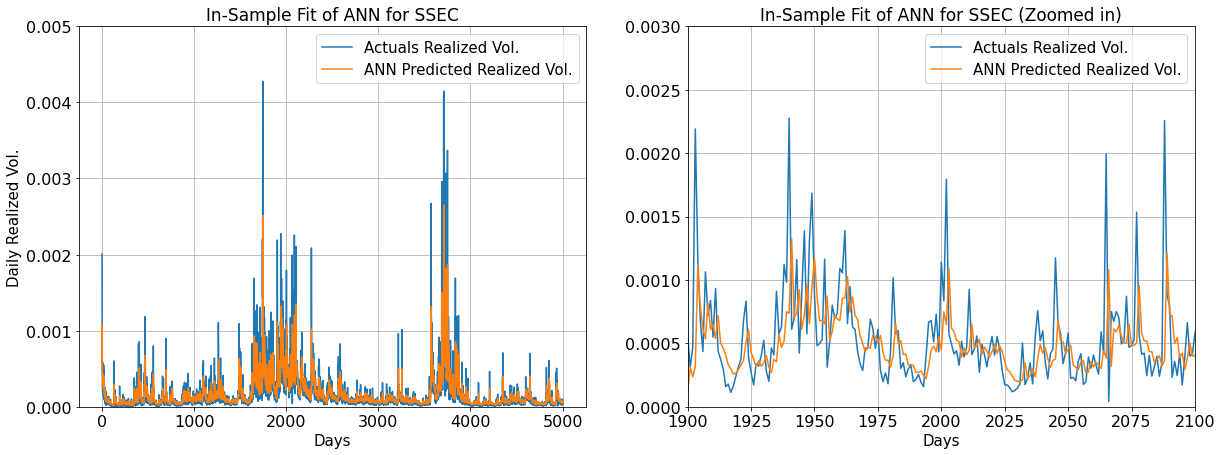

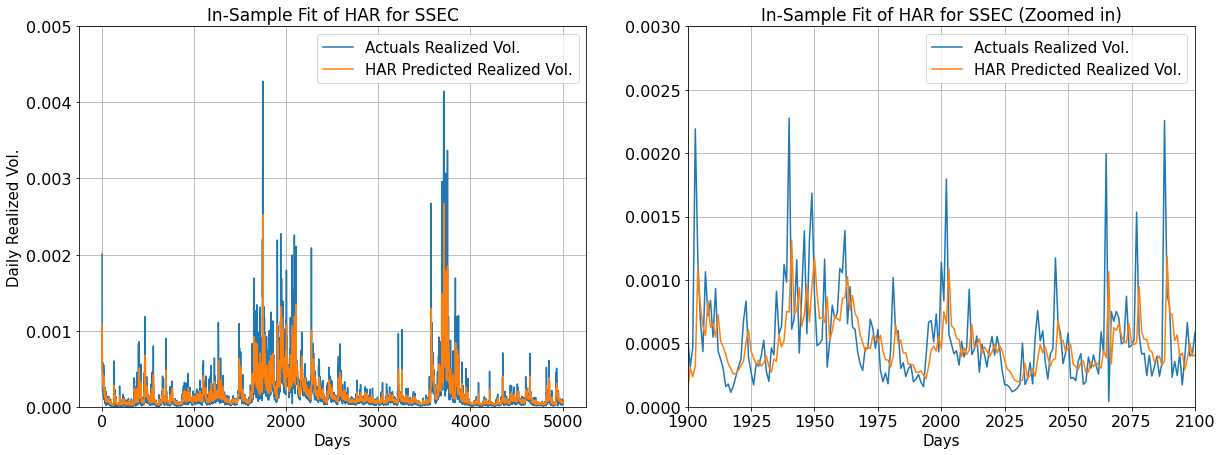

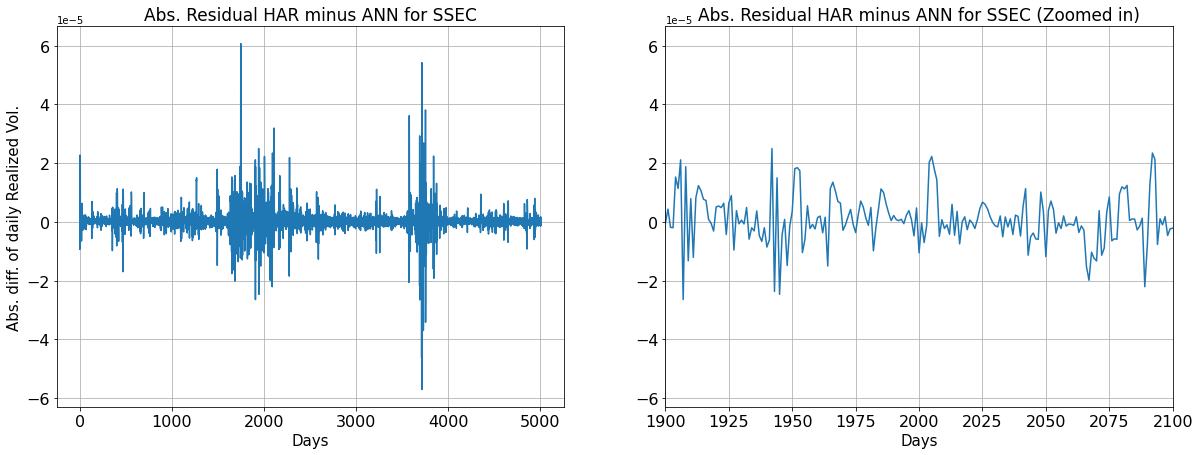

In [7]:
###################################################################################################
xstart, xend = 1900, 2100
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs[0].plot(data_nn_train.y_t.detach().numpy().reshape(-1), label="Actuals Realized Vol.")
axs[0].plot(best_output, label="ANN Predicted Realized Vol.")
axs[0].set_title(f"In-Sample Fit of ANN for {ticker[1:]}", fontsize = 17)
axs[0].set_ylabel("Daily Realized Vol.", fontsize=15)
axs[0].set_ylim(0, 0.005)

axs[1].plot(data_nn_train.y_t.detach().numpy().reshape(-1), label="Actuals Realized Vol.")
axs[1].plot(best_output, label="ANN Predicted Realized Vol.")
axs[1].set_title(f"In-Sample Fit of ANN for {ticker[1:]} (Zoomed in)", fontsize = 17)
axs[1].set_xlim(xstart,xend)
axs[1].set_ylim(0, 0.003)

for ax in axs:
    ax.set_xlabel("Days", fontsize=15)
    ax.tick_params(labelsize = 16)
    ax.legend(fontsize=15)
    ax.grid()
plt.savefig(f"images/insamplebestfit_ann_{ticker[1:]}.png", dpi=200)
plt.show()

###################################################################################################

xstart, xend = 1900, 2100
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs[0].plot(data_har_train.y.reshape(-1), label="Actuals Realized Vol.")
axs[0].plot(har_output, label="HAR Predicted Realized Vol.")
axs[0].set_title(f"In-Sample Fit of HAR for {ticker[1:]}", fontsize = 17)
axs[0].set_ylabel("Daily Realized Vol.", fontsize=15)
axs[0].set_ylim(0, 0.005)

axs[1].plot(data_har_train.y.reshape(-1), label="Actuals Realized Vol.")
axs[1].plot(har_output, label="HAR Predicted Realized Vol.")
axs[1].set_title(f"In-Sample Fit of HAR for {ticker[1:]} (Zoomed in)", fontsize = 17)
axs[1].set_xlim(xstart,xend)
axs[1].set_ylim(0, 0.003)

for ax in axs:
    ax.set_xlabel("Days", fontsize=15)
    ax.tick_params(labelsize = 16)
    ax.legend(fontsize=15)
    ax.grid()
plt.savefig(f"images/insamplebestfit_har_{ticker[1:]}.png", dpi=200)
plt.show()

###################################################################################################
nn_resid = data_har_train.y.reshape(-1) - best_output
har_resid = data_har_train.y.reshape(-1) - har_output
abs_diff = abs(har_resid) - abs(nn_resid)

xstart, xend = 1900, 2100
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs[0].plot(abs_diff)
axs[0].set_title(f"Abs. Residual HAR minus ANN for {ticker[1:]}", fontsize = 17)
axs[0].set_ylabel("Abs. diff. of daily Realized Vol.", fontsize=15)
# axs[0].set_ylim(0, 0.005)

axs[1].plot(abs_diff)
axs[1].set_title(f"Abs. Residual HAR minus ANN for {ticker[1:]} (Zoomed in)", fontsize = 17)
axs[1].set_xlim(xstart,xend)
# axs[1].set_ylim(0, 0.003)

ax.set_xlabel("Days", fontsize=15)
ax.tick_params(labelsize = 16)
ax.grid()
for ax in axs:
    ax.set_xlabel("Days", fontsize=15)
    ax.tick_params(labelsize = 16)
    ax.grid()
plt.savefig(f"images/insamplebestfit_har_nn_diff_{ticker[1:]}.png", dpi=200)
plt.show()

### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [12]:
# PERFORM CROSS VALIDATION
model_scores = []

hidden_layers_list: tuple = ([2,],)
lr_list: tuple = (5e-3, 1e-3, 5e-4)
epochs_list: tuple = (1000,)
patience_list: tuple = (5, 10, 20)
batch_sizes: tuple = (10,)
total_model_options: int = len(hidden_layers_list) * len(lr_list) * len(epochs_list) * len(batch_sizes) * len(patience_list)
number_of_repeated_kfolds: int = int(10)

# for all possible model and estimation configurations, perform kfold cross validation
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patience_list:
            
                    counter += 1
                    print(f"Currently at model: {counter} / {total_model_options}", end="\r")
                    
                    avg_score_multiple_folds_list = [           
                        # fit and evaluate model through cross validation
                        kfolds_fit_and_evaluate_model(
                            input_size = data_nn_train.x_t.shape[1],
                            output_size = 1,
                            hidden_layers = hidden_layers,
                            # kfold = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 500, gap = 25), # the test_size = len(data) // (n_splits + 1)
                            kfold = TimeSeriesSplit(n_splits = 8, max_train_size = None, test_size = 300, gap = 25), # the test_size = len(data) // (n_splits + 1)
                            data = data_nn_train,
                            lr = lr, 
                            epochs = epochs, 
                            earlystopper = EarlyStopper(patience=patience, min_delta=0),
                            normalize_features = False,
                            batch_size = batch_size,
                        )
                        for i in range(number_of_repeated_kfolds)
                    ]
                    
                    avg_score_multiple_folds = np.average(avg_score_multiple_folds_list)
                    
                    print(f"model: hidden layers={hidden_layers} lr={lr} epochs={epochs} batch_size={batch_size} patience={patience}")
                    print(f"avg score: {avg_score_multiple_folds} list of scores: {avg_score_multiple_folds_list}")
                    
                    # store the models performance in array
                    model_scores += [(avg_score_multiple_folds, epochs, hidden_layers, lr, batch_size, patience)]
                    # model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr", "batch_size", 'patience'])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

model: hidden layers=[2] lr=0.005 epochs=1000 batch_size=10 patience=5
avg score: 9.744894668983761e-08 list of scores: [8.028259e-08, 4.9302734e-08, 6.731633e-08, 5.9200183e-08, 4.685173e-08, 3.8369013e-08, 8.5799826e-08, 4.3353248e-07, 5.2879262e-08, 6.095537e-08]
model: hidden layers=[2] lr=0.005 epochs=1000 batch_size=10 patience=10
avg score: 1.015114889924007e-07 list of scores: [5.5919607e-08, 5.630723e-08, 6.787138e-08, 8.3272504e-08, 7.225181e-08, 1.2202622e-07, 1.9044344e-07, 2.1010413e-07, 4.8518558e-08, 1.0839998e-07]
model: hidden layers=[2] lr=0.005 epochs=1000 batch_size=10 patience=20
avg score: 1.6686348658367933e-07 list of scores: [1.2273473e-07, 4.352654e-08, 6.251483e-07, 2.269424e-07, 6.9173694e-08, 7.400037e-08, 1.2030699e-07, 2.0471592e-07, 1.1366796e-07, 6.841794e-08]
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=5
avg score: 6.124842855115276e-08 list of scores: [5.82713e-08, 5.4599834e-08, 8.952237e-08, 6.9969914e-08, 5.0249305e-08, 5.8

### Fit and Compare the Final Neural Network Against the HAR Model

No params from cross validation, using own params instead
Or specifically specified to use own params
HAR out-of-sample loss: 2.7338040720081835e-09


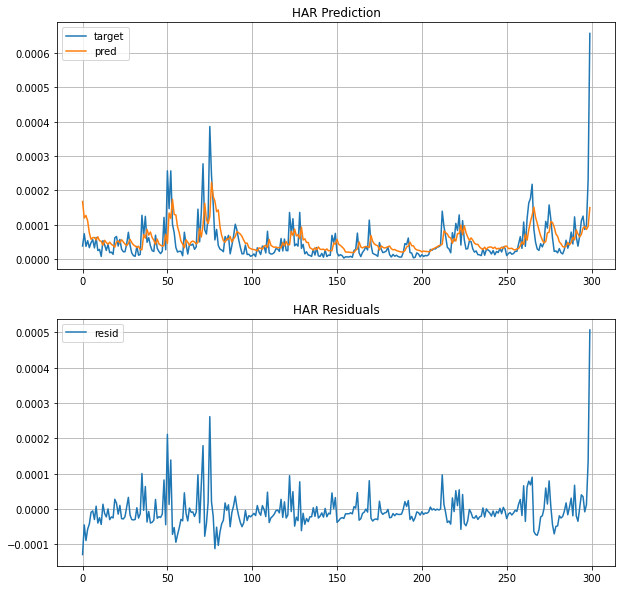

Estimating NN model ...
... with epochs=1000, hidden_layers=[2], lr=0.001
NN out-of-sample loss: 1.0268538019886364e-08 - best loss: inf


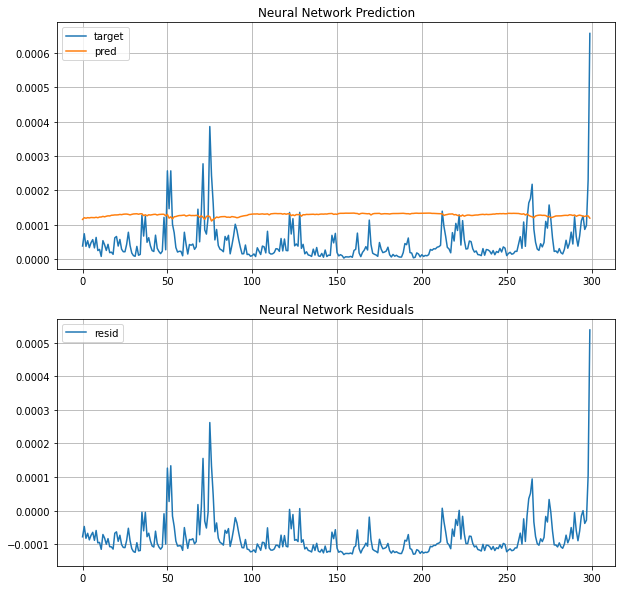

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 19.690910444108468 p_val: 1.0
NN out-of-sample loss: 7.343083474609102e-09 - best loss: 1.0268538019886364e-08


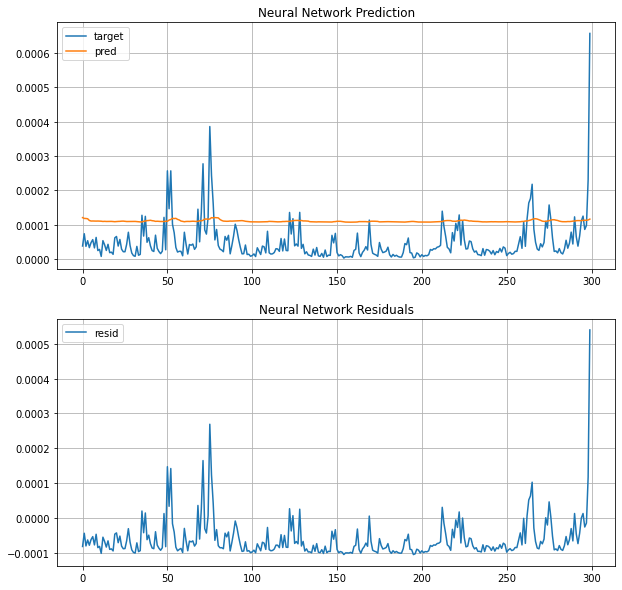

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 16.06530055461506 p_val: 1.0
NN out-of-sample loss: 7.699650694803495e-09 - best loss: 7.343083474609102e-09
NN out-of-sample loss: 6.2039893222731735e-09 - best loss: 7.343083474609102e-09


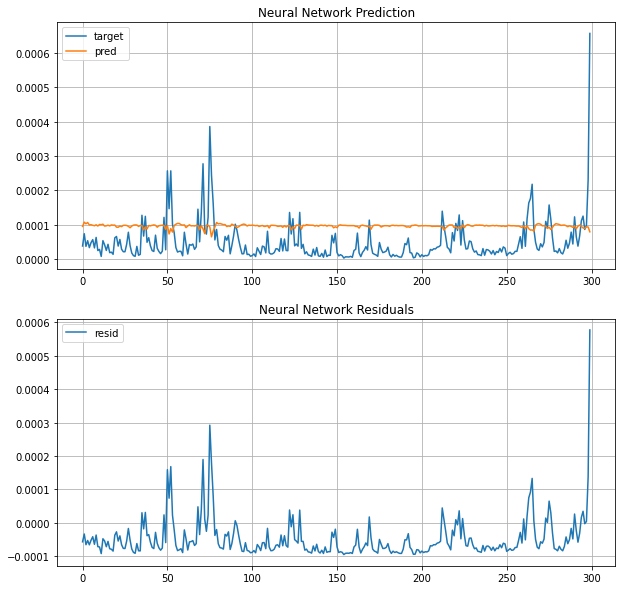

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 9.911175388252333 p_val: 1.0
NN out-of-sample loss: 1.0133060612815825e-08 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 6.608336988733754e-09 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 2.2870569438282473e-08 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 9.150733504270647e-09 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 7.73449748692201e-09 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 2.0439340886468926e-08 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 7.473828667059479e-09 - best loss: 6.2039893222731735e-09
NN out-of-sample loss: 4.741815828879226e-09 - best loss: 6.2039893222731735e-09


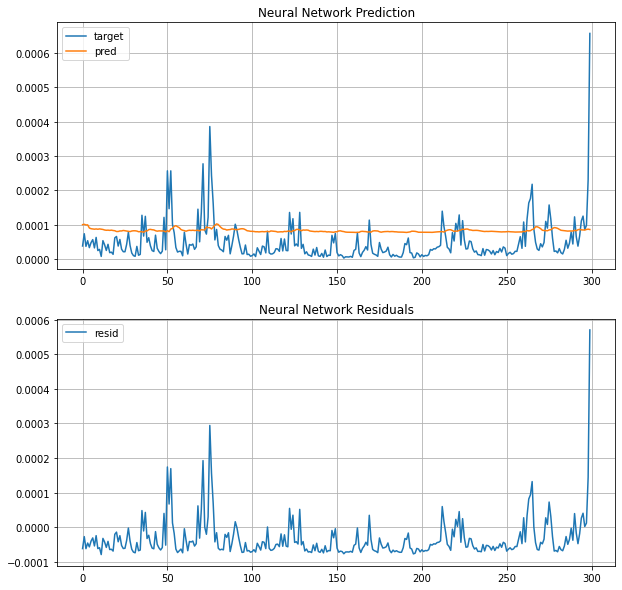

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 6.810326409497794 p_val: 0.9999999999732606
NN out-of-sample loss: 9.720841909199862e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 7.191032658226959e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 8.401604745245095e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 8.715848487383937e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 8.324002820359055e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 5.350144771654186e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 7.456159245577965e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 7.109002275740295e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 8.978486398802943e-09 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 2.224853901111601e-08 - best loss: 4.741815828879226e-09
NN out-of-sample loss: 1.897137913431379

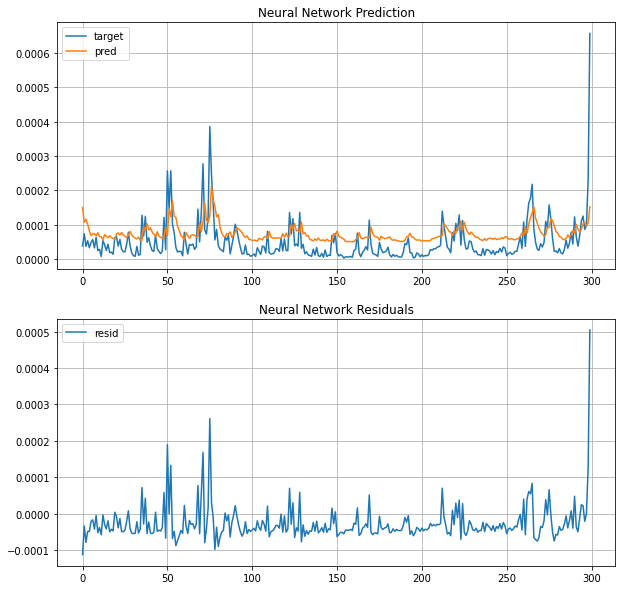

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 6.974323399276141 p_val: 0.9999999999901136
NN out-of-sample loss: 8.244765759002348e-09 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 9.099625941644263e-09 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 6.574749189525164e-09 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 8.088279379592223e-09 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 6.4707847968747956e-09 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 1.4010353766025219e-08 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 1.0432787966863089e-08 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 1.533171101186781e-08 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 1.6583923567736747e-08 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 4.197742153877471e-09 - best loss: 3.3289195844332653e-09
NN out-of-sample loss: 6.0

KeyboardInterrupt: 

In [15]:
normalize_features = False
use_own_config = True # !!! if you use this once after the cross validation, the custom hyperparams below 'overwrite' those from cross validation above

# sometimes we want to zoom in on specific intervals of the forecast
idx_start, idx_end = 0, 10000

# if the params are not set through cross validations above
try:
    epochs, lr, hidden_layers
    if use_own_config: raise Exception()
except Exception as e:
    print("No params from cross validation, using own params instead")
    print("Or specifically specified to use own params")
    epochs = int(1e3)
    hidden_layers = [2,] # zero or one with 2 nodes
    lr = 1e-3 # 1e-3, 5e-4
    batch_size = 10
    patience = 3

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
# the goal was to instantiate the model before passing it to the estimation function, so we can use the model here
# this does not work
HAR = OLS(np.zeros(10), np.zeros(10)) # these params are placeholders
loss, output = fit_and_evaluateHAR(
    model = HAR,
    data_train = data_har_train,
    data_test = data_har_val,
    normalize_features = False
)
har_loss = loss
har_output = output.copy().reshape(-1,)

print(f"HAR out-of-sample loss: {loss}")

plot = True
if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (10, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(data_har_val.y[idx_start:idx_end], label = "target")
    axs[0].plot(output[idx_start:idx_end], label = "pred")
    axs[1].plot((data_har_val.y - output)[idx_start:idx_end], label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================
print("Estimating NN model ...")
print(f"... with epochs={epochs}, hidden_layers={hidden_layers}, lr={lr}")

best_loss = float("inf")
while True:
    NN = ForwardNeuralNetwork(
        data_nn_train.x_t.shape[1], 
        output_size = 1, 
        hidden_layers=hidden_layers, 
        # seed=3407
        )
    nn_loss, output = single_fit_and_evaluate_model(
        NN,
        data_train = data_nn_train,
        data_test = data_nn_val,
        lr = lr,
        epochs = epochs,
        earlystopper = EarlyStopper(patience=patience, min_delta=0),
        normalize_features = False,
        return_prediction = True,
        batch_size=batch_size
    )

    nn_output =  output.detach().numpy().reshape(-1,)
    true_output = data_har_val.y.reshape(-1,)
    print(f"NN out-of-sample loss: {nn_loss} - best loss: {best_loss}")
    
    if nn_loss < best_loss: 
        best_loss = nn_loss

        plot = True
        if plot:
            # plot prediction versus true daily volatility
            fig, axs = plt.subplots(2,1, figsize = (10,10))
            axs[0].set_title("Neural Network Prediction")
            axs[1].set_title("Neural Network Residuals")
            axs[0].plot(data_nn_val.y_t.detach().numpy().reshape(-1,)[idx_start:idx_end], label = "target")
            axs[0].plot(output.detach().numpy()[idx_start:idx_end], label = "pred")
            axs[1].plot( (data_nn_val.y_t.detach().numpy().reshape(-1,) - output.detach().numpy().reshape(-1,))[idx_start:idx_end], label = "resid")
            
            for ax in axs:
                ax.legend()
                ax.grid()
            plt.show()
    
        #=========================================================================================
        #====================================DIEBOLD-MARIANO======================================
        #=========================================================================================
        stat, p_value = dm_test(
            data_har_val.y, 
            nn_output,
            har_output, 
            one_sided=True,
        )
        print("Diebold-Mariano test")
        print("H0: stat = 0, H1: stat < 0")
        print("I.e., p-val < p_crit implies NN performs significantly better")
        print(f"stat: {stat} p_val: {p_value}")
        # if one sided, only test if the upper forecast performs significantly better than the lower forecast

In [6]:
for name, param in NN.named_parameters():
    if param.requires_grad:
        print(name, param.data[0])

layers.0.weight tensor([0.2862, 0.6051, 0.0553])
layers.0.bias tensor(0.0003)


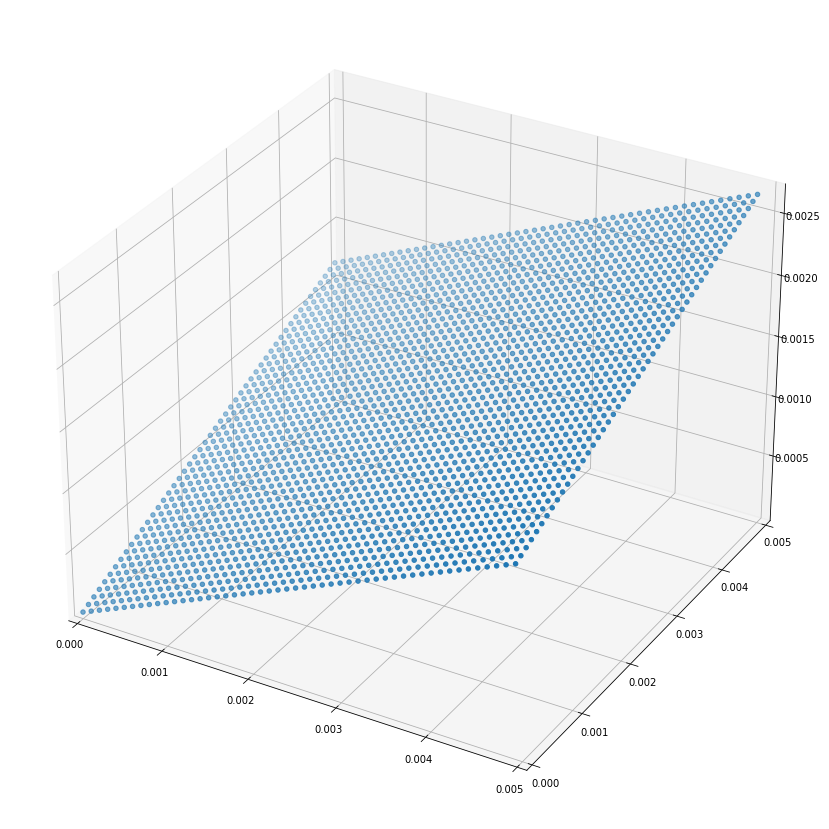

In [125]:
X = np.arange(0, 0.005, .0001)
Y = np.arange(0, 0.005, .0001)
Zconstant = 0
NN = model
features = np.zeros((len(X)*len(Y), 3))
i = 0
for Xi in X:
    for Yi in Y:
        features[i] = (Zconstant, Xi, Yi)
        i += 1
X = torch.tensor(features, dtype=torch.float32)

Y = NN(X).detach().numpy().reshape(-1,)
X = X.detach().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

X, Y, Z = X[:,1], X[:, 2], Y
ax.scatter(X, Y, Z)
ax.set_xlim(0, 0.005)
ax.set_ylim(0, 0.005)
ax.set_zlim(min(Z), max(Z))
plt.show()


In [4]:
kfold = TimeSeriesSplit(n_splits = 8, max_train_size = None, test_size=300, gap=25)
for idx_train, idx_test in kfold.split(data_nn_train.x_t):
    train_start, train_end = idx_train[0], idx_train[-1]
    test_start, test_end = idx_test[0], idx_test[-1]
    print(train_start, train_end, "-", test_start, test_end)


0 2782 - 2808 3107
0 3082 - 3108 3407
0 3382 - 3408 3707
0 3682 - 3708 4007
0 3982 - 4008 4307
0 4282 - 4308 4607
0 4582 - 4608 4907
0 4882 - 4908 5207


In [121]:
for layer in model.layers:
    if hasattr(layer, "weight"):
        print("-----------layer----------")
        print(layer.weight, layer.bias)

-----------layer----------
Parameter containing:
tensor([[-9.5121, -8.4270, -6.6839]], requires_grad=True) Parameter containing:
tensor([-0.6892], requires_grad=True)
-----------layer----------
Parameter containing:
tensor([[-0.1645]], requires_grad=True) Parameter containing:
tensor([0.0550], requires_grad=True)


In [7]:
this = {
	"name": "TypeError",
	"message": "object of type 'float' has no len()",
	"stack": "\u001b[0;31m---------------------------------------------------------------------------\u001b[0m\n\u001b[0;31mTypeError\u001b[0m                                 Traceback (most recent call last)\n\u001b[0;32m<ipython-input-6-18b14058487f>\u001b[0m in \u001b[0;36m<module>\u001b[0;34m\u001b[0m\n\u001b[1;32m     21\u001b[0m                     \u001b[0mprint\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0;34mf\"Currently at model: {counter} / {total_model_options}\"\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mend\u001b[0m\u001b[0;34m=\u001b[0m\u001b[0;34m\"\\r\"\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m     22\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m---> 23\u001b[0;31m                     avg_score_multiple_folds_list = [           \n\u001b[0m\u001b[1;32m     24\u001b[0m                         \u001b[0;31m# fit and evaluate model through cross validation\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m     25\u001b[0m                         kfolds_fit_and_evaluate_model(\n\n\u001b[0;32m<ipython-input-6-18b14058487f>\u001b[0m in \u001b[0;36m<listcomp>\u001b[0;34m(.0)\u001b[0m\n\u001b[1;32m     23\u001b[0m                     avg_score_multiple_folds_list = [           \n\u001b[1;32m     24\u001b[0m                         \u001b[0;31m# fit and evaluate model through cross validation\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m---> 25\u001b[0;31m                         kfolds_fit_and_evaluate_model(\n\u001b[0m\u001b[1;32m     26\u001b[0m                             \u001b[0minput_size\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mdata_nn_train\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mx_t\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mshape\u001b[0m\u001b[0;34m[\u001b[0m\u001b[0;36m1\u001b[0m\u001b[0;34m]\u001b[0m\u001b[0;34m,\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m     27\u001b[0m                             \u001b[0moutput_size\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0;36m1\u001b[0m\u001b[0;34m,\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\n\u001b[0;32m~/casestudy/casestudy-neural-networks/utils/estimating.py\u001b[0m in \u001b[0;36mkfolds_fit_and_evaluate_model\u001b[0;34m(input_size, output_size, hidden_layers, kfold, data, lr, epochs, earlystopper, normalize_features, batch_size)\u001b[0m\n\u001b[1;32m    182\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    183\u001b[0m         \u001b[0;31m# estimate the data\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m--> 184\u001b[0;31m         \u001b[0mloss\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0msingle_fit_and_evaluate_model\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mmodel\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mdata_train\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mdata_test\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mlr\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mepochs\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mearlystopper\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mnormalize_features\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mreturn_prediction\u001b[0m\u001b[0;34m=\u001b[0m\u001b[0;32mFalse\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mbatch_size\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mbatch_size\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m\u001b[1;32m    185\u001b[0m         \u001b[0mscore_nn\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mappend\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mloss\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    186\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\n\u001b[0;32m~/casestudy/casestudy-neural-networks/utils/estimating.py\u001b[0m in \u001b[0;36msingle_fit_and_evaluate_model\u001b[0;34m(model, lr, epochs, data_train, data_test, earlystopper, normalize_features, return_prediction, batch_size)\u001b[0m\n\u001b[1;32m    213\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    214\u001b[0m     \u001b[0;31m# NOTE: SHOULD SHUFFLE BE TRUE OR FALSE, WAS FALSE UNTIL NOW\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m--> 215\u001b[0;31m     \u001b[0mloader_train\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mDataLoader\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mdata_train\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mbatch_size\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mbatch_size\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mshuffle\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0;32mTrue\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m\u001b[1;32m    216\u001b[0m     \u001b[0mloader_test\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mDataLoader\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mdata_test\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mbatch_size\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mbatch_size\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mshuffle\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0;32mTrue\u001b[0m\u001b[0;34m)\u001b[0m \u001b[0;32mif\u001b[0m \u001b[0mdata_test\u001b[0m \u001b[0;32melse\u001b[0m \u001b[0;32mNone\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    217\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\n\u001b[0;32m/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py\u001b[0m in \u001b[0;36m__init__\u001b[0;34m(self, dataset, batch_size, shuffle, sampler, batch_sampler, num_workers, collate_fn, pin_memory, drop_last, timeout, worker_init_fn, multiprocessing_context, generator, prefetch_factor, persistent_workers)\u001b[0m\n\u001b[1;32m    268\u001b[0m                     \u001b[0;31m# Cannot statically verify that dataset is Sized\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    269\u001b[0m                     \u001b[0;31m# Somewhat related: see NOTE [ Lack of Default `__len__` in Python Abstract Base Classes ]\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m--> 270\u001b[0;31m                     \u001b[0msampler\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mRandomSampler\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mdataset\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mgenerator\u001b[0m\u001b[0;34m=\u001b[0m\u001b[0mgenerator\u001b[0m\u001b[0;34m)\u001b[0m  \u001b[0;31m# type: ignore[arg-type]\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m\u001b[1;32m    271\u001b[0m                 \u001b[0;32melse\u001b[0m\u001b[0;34m:\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    272\u001b[0m                     \u001b[0msampler\u001b[0m \u001b[0;34m=\u001b[0m \u001b[0mSequentialSampler\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mdataset\u001b[0m\u001b[0;34m)\u001b[0m  \u001b[0;31m# type: ignore[arg-type]\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\n\u001b[0;32m/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/sampler.py\u001b[0m in \u001b[0;36m__init__\u001b[0;34m(self, data_source, replacement, num_samples, generator)\u001b[0m\n\u001b[1;32m     99\u001b[0m                              \"since a random permute will be performed.\")\n\u001b[1;32m    100\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m--> 101\u001b[0;31m         \u001b[0;32mif\u001b[0m \u001b[0;32mnot\u001b[0m \u001b[0misinstance\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mself\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mnum_samples\u001b[0m\u001b[0;34m,\u001b[0m \u001b[0mint\u001b[0m\u001b[0;34m)\u001b[0m \u001b[0;32mor\u001b[0m \u001b[0mself\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mnum_samples\u001b[0m \u001b[0;34m<=\u001b[0m \u001b[0;36m0\u001b[0m\u001b[0;34m:\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m\u001b[1;32m    102\u001b[0m             raise ValueError(\"num_samples should be a positive integer \"\n\u001b[1;32m    103\u001b[0m                              \"value, but got num_samples={}\".format(self.num_samples))\n\n\u001b[0;32m/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/sampler.py\u001b[0m in \u001b[0;36mnum_samples\u001b[0;34m(self)\u001b[0m\n\u001b[1;32m    107\u001b[0m         \u001b[0;31m# dataset size might change at runtime\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    108\u001b[0m         \u001b[0;32mif\u001b[0m \u001b[0mself\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0m_num_samples\u001b[0m \u001b[0;32mis\u001b[0m \u001b[0;32mNone\u001b[0m\u001b[0;34m:\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0;32m--> 109\u001b[0;31m             \u001b[0;32mreturn\u001b[0m \u001b[0mlen\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mself\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mdata_source\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m\u001b[1;32m    110\u001b[0m         \u001b[0;32mreturn\u001b[0m \u001b[0mself\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0m_num_samples\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[1;32m    111\u001b[0m \u001b[0;34m\u001b[0m\u001b[0m\n\n\u001b[0;31mTypeError\u001b[0m: object of type 'float' has no len()"
}

In [9]:
print(this["stack"])

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-6-18b14058487f> in <module>
     21                     print(f"Currently at model: {counter} / {total_model_options}", end="\r")
     22 
---> 23                     avg_score_multiple_folds_list = [           
     24                         # fit and evaluate model through cross validation
     25                         kfolds_fit_and_evaluate_model(

<ipython-input-6-18b14058487f> in <listcomp>(.0)
     23                     avg_score_multiple_folds_list = [           
     24                         # fit and evaluate model through cross validation
---> 25                         kfolds_fit_and_evaluate_model(
     26                             input_size = data_nn_train.x_t.shape[1],
     27                             output_size = 1,

~/casestudy/casestudy-neural-networks/utils/estimating.py in kfolds_fit_and_e

In [12]:
data_nn_train.x_t.shape

torch.Size([5208, 3])

In [13]:
DataLoader(data_nn_train)